Обучение модели с помощью CatBoostClassifier

In [4]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

train_df = pd.read_csv('cleaned_train.csv')
valid_df = pd.read_csv('cleaned_valid.csv')
# train_df = pd.read_csv("../AC/trein.csv")
# valid_df = pd.read_csv("../AC/val.csv")

In [5]:
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

X_val = valid_df.drop(columns=['target'])
y_val = valid_df['target']

Инициализация и настройка модели XGBoost с подбором гиперпараметров

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'random_state': 1
}

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:report_date: object, col1454: object

In [7]:
y_prob = xgb_model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

NameError: name 'xgb_model' is not defined

Построение ROC-кривой

ROC-AUC: 0.5753


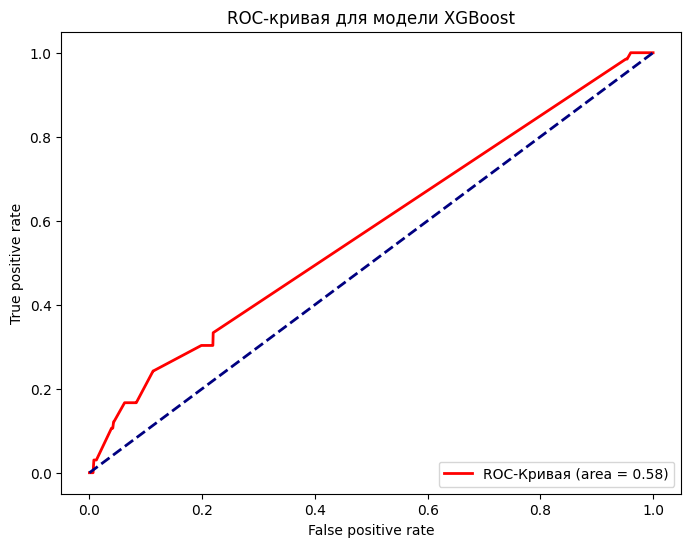

In [19]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Загрузка данных
train_df = pd.read_csv('train_edit.csv')
valid_df = pd.read_csv('valid_edit.csv')
# train_df = pd.read_csv("../AC/trein.csv")
# valid_df = pd.read_csv("../AC/val.csv")
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

X_val = valid_df.drop(columns=['target'])
y_val = valid_df['target']

# Преобразование типов данных в числовые (int или float)
for col in X_train.columns:
    if X_train[col].dtype not in ['int64', 'float64', 'int32', 'float32']:
        try:
            X_train[col] = pd.to_numeric(X_train[col])
        except ValueError:
           print(f"Не удалось преобразовать столбец {col}, возможно не числовой")
           X_train = X_train.drop(columns=[col])
           
for col in X_val.columns:
     if X_val[col].dtype not in ['int64', 'float64', 'int32', 'float32']:
        try:
           X_val[col] = pd.to_numeric(X_val[col])
        except ValueError:
           print(f"Не удалось преобразовать столбец {col}, возможно не числовой")
           X_val = X_val.drop(columns=[col])

# Инициализация и настройка модели XGBoost с подбором гиперпараметров
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'random_state': 1
}

# Обучение модели XGBoost
xgb_model = xgb.train(params, dtrain)

# Получение предсказаний вероятностей
y_prob = xgb_model.predict(dval)

# Расчет ROC-AUC
roc_auc = roc_auc_score(y_val, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC-Кривая (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-кривая для модели XGBoost')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.9819
ROC AUC: 0.6502


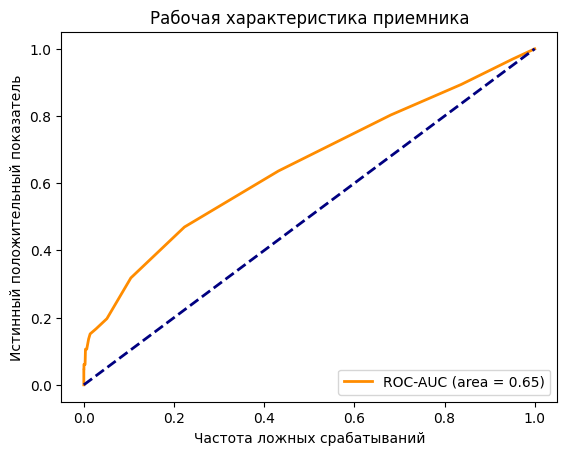

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score


# Загрузка данных
train_df = pd.read_csv('train_edit.csv')
valid_df = pd.read_csv('valid_edit.csv')
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

X_val = valid_df.drop(columns=['target'])
y_val = valid_df['target']


# Преобразование типов данных в числовые (int или float)
for col in X_train.columns:
    if X_train[col].dtype not in ['int64', 'float64', 'int32', 'float32']:
        try:
            X_train[col] = pd.to_numeric(X_train[col])
        except ValueError:
           print(f"Не удалось преобразовать столбец {col}, возможно не числовой")
           X_train = X_train.drop(columns=[col])
           
for col in X_val.columns:
     if X_val[col].dtype not in ['int64', 'float64', 'int32', 'float32']:
        try:
           X_val[col] = pd.to_numeric(X_val[col])
        except ValueError:
           print(f"Не удалось преобразовать столбец {col}, возможно не числовой")
           X_val = X_val.drop(columns=[col])


# Инициализация и обучение модели
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# Предсказание на валидационных данных
y_pred = model.predict(X_val)  # Исправлено: X_test -> X_val
accuracy = accuracy_score(y_val, y_pred) # Исправлено: y_test -> y_val

# Получение вероятностей для ROC-кривой
y_prob = model.predict_proba(X_val)[:, 1] # Исправлено: X_test -> X_val

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_val, y_prob) # Исправлено: y_test -> y_val
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Частота ложных срабатываний')
plt.ylabel('Истинный положительный показатель')
plt.title('Рабочая характеристика приемника')
plt.legend(loc='lower right')
plt.show()